## FastSLAM1.0

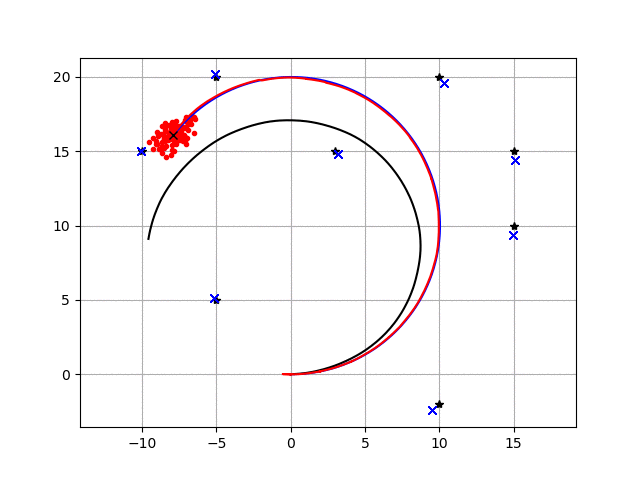

In [1]:
from IPython.display import Image
Image(filename="animation.png",width=600)

### Simulation

This is a feature based SLAM example using FastSLAM 1.0.

The blue line is ground truth, the black line is dead reckoning, the red
line is the estimated trajectory with FastSLAM.

The red points are particles of FastSLAM.

Black points are landmarks, blue crosses are estimated landmark
positions by FastSLAM.


![gif](https://github.com/AtsushiSakai/PythonRoboticsGifs/raw/master/SLAM/FastSLAM1/animation.gif)

### Introduction

FastSLAM algorithm implementation is based on particle filters and belongs to the family of probabilistic SLAM approaches. It is used with feature-based maps (see gif above) or  with occupancy grid maps.

As it is shown, the particle filter differs from EKF by representing the robot's estimation through a set of particles. Each single particle has an independent belief, as it holds the pose $(x, y, \theta)$ and an array of landmark locations $[(x_1, y_1), (x_2, y_2), ... (x_n, y_n)]$ for n landmarks.

* The blue line is the true trajectory
* The red line is the estimated trajectory
* The red dots represent the distribution of particles
* The black line represent dead reckoning tracjectory
* The blue x is the observed and estimated landmarks
* The black x is the true landmark

I.e. Each particle maintains a deterministic pose and n-EKFs for each landmark and update it with each measurement.

### Algorithm walkthrough

The particles are initially drawn from a uniform distribution the represent the initial uncertainty.
At each time step we do:

* Predict the pose for each particle by using $u$ and the motion model (the landmarks are not updated). 
* Update the particles with observations $z$, where the weights are adjusted based on how likely the particle to have the correct pose given the sensor measurement
* Resampling such that the particles with the largest weights survive and the unlikely ones with the lowest weights die out.



### 1- Predict
The following equations and code snippets we can see how the particles distribution evolves in case we provide only the control $(v,w)$, which are the linear and angular velocity repsectively. 

$\begin{equation*}
F=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
X = FX + BU 
\end{equation*}$


$\begin{equation*}
\begin{bmatrix}
x_{t+1} \\
y_{t+1} \\
\theta_{t+1}
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}\begin{bmatrix}
x_{t} \\
y_{t} \\
\theta_{t}
\end{bmatrix}+
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\begin{bmatrix}
v_{t} + \sigma_v\\
w_{t} + \sigma_w\\
\end{bmatrix}
\end{equation*}$



The following snippets playsback the recorded trajectory of each particle.

To get the insight of the motion model change the value of $R$ and re-run the cells again. As R is the parameters that indicates how much we trust that the robot executed the motion commands.

It is interesting to notice also that only motion will increase the uncertainty in the system as the particles start to spread out more. If observations are included the uncertainty will decrease and particles will converge to the correct estimate.

In [2]:
# CODE SNIPPET #
import numpy as np
import math
from copy import deepcopy
# Fast SLAM covariance
Q = np.diag([3.0, np.deg2rad(10.0)])**2
R = np.diag([1.0, np.deg2rad(20.0)])**2

#  Simulation parameter
Qsim = np.diag([0.3, np.deg2rad(2.0)])**2
Rsim = np.diag([0.5, np.deg2rad(10.0)])**2
OFFSET_YAWRATE_NOISE = 0.01

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # LM srate size [x,y]
N_PARTICLE = 100  # number of particle
NTH = N_PARTICLE / 1.5  # Number of particle for re-sampling

class Particle:

    def __init__(self, N_LM):
        self.w = 1.0 / N_PARTICLE
        self.x = 0.0
        self.y = 0.0
        self.yaw = 0.0
        # landmark x-y positions
        self.lm = np.zeros((N_LM, LM_SIZE))
        # landmark position covariance
        self.lmP = np.zeros((N_LM * LM_SIZE, LM_SIZE))

def motion_model(x, u):
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])
    x = F @ x + B @ u
        
    x[2, 0] = pi_2_pi(x[2, 0])
    return x
    
def predict_particles(particles, u):
    for i in range(N_PARTICLE):
        px = np.zeros((STATE_SIZE, 1))
        px[0, 0] = particles[i].x
        px[1, 0] = particles[i].y
        px[2, 0] = particles[i].yaw
        ud = u + (np.random.randn(1, 2) @ R).T  # add noise
        px = motion_model(px, ud)
        particles[i].x = px[0, 0]
        particles[i].y = px[1, 0]
        particles[i].yaw = px[2, 0]

    return particles

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

# END OF SNIPPET

N_LM = 0 
particles = [Particle(N_LM) for i in range(N_PARTICLE)]
time= 0.0
v = 1.0  # [m/s]
yawrate = 0.1  # [rad/s]
u = np.array([v, yawrate]).reshape(2, 1)
history = []
while SIM_TIME >= time:
    time += DT
    particles = predict_particles(particles, u)
    history.append(deepcopy(particles))


In [3]:
# from IPython.html.widgets import *
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# playback the recorded motion of the particles
def plot_particles(t=0):
    x = []
    y = []
    for i in range(len(history[t])):
        x.append(history[t][i].x)
        y.append(history[t][i].y)
    plt.figtext(0.15,0.82,'t = ' + str(t))
    plt.plot(x, y, '.r')
    plt.axis([-20,20, -5,25])

interact(plot_particles, t=(0,len(history)-1,1));

interactive(children=(IntSlider(value=0, description='t', max=499), Output()), _dom_classes=('widget-interact'…

### 2- Update

For the update step it is useful to observe a single particle and the effect of getting a new measurements on the weight of the particle.

As mentioned earlier, each particle maintains $N$ $2x2$ EKFs to estimate the landmarks, which includes the EKF process described in the EKF notebook. The difference is the change in the weight of the particle according to how likely the measurement is.

The weight is updated according to the following equation: 

$\begin{equation*}
w_i = |2\pi Q|^{\frac{-1}{2}} exp\{\frac{-1}{2}(z_t - \hat z_i)^T Q^{-1}(z_t-\hat z_i)\}
\end{equation*}$

Where, $w_i$ is the computed weight, $Q$ is the measurement covariance, $z_t$ is the actual measurment and $\hat z_i$ is the predicted measurement of particle $i$.

To experiment this, a single particle is initialized then passed an initial measurement, which results in a relatively average weight. However, setting the particle coordinate to a wrong value to simulate wrong estimation will result in a very low weight. The lower the weight the less likely that this particle will be drawn during resampling and probably will die out.

In [4]:
# CODE SNIPPET #
def observation(xTrue, xd, u, RFID):

    # calc true state
    xTrue = motion_model(xTrue, u)

    # add noise to range observation
    z = np.zeros((3, 0))
    for i in range(len(RFID[:, 0])):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx) - xTrue[2, 0])
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.array([dn, pi_2_pi(anglen), i]).reshape(3, 1)
            z = np.hstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1] + OFFSET_YAWRATE_NOISE
    ud = np.array([ud1, ud2]).reshape(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

def update_with_observation(particles, z):
    for iz in range(len(z[0, :])):

        lmid = int(z[2, iz])

        for ip in range(N_PARTICLE):
            # new landmark
            if abs(particles[ip].lm[lmid, 0]) <= 0.01:
                particles[ip] = add_new_lm(particles[ip], z[:, iz], Q)
            # known landmark
            else:
                w = compute_weight(particles[ip], z[:, iz], Q)
                particles[ip].w *= w
                particles[ip] = update_landmark(particles[ip], z[:, iz], Q)

    return particles

def compute_weight(particle, z, Q):
    lm_id = int(z[2])
    xf = np.array(particle.lm[lm_id, :]).reshape(2, 1)
    Pf = np.array(particle.lmP[2 * lm_id:2 * lm_id + 2])
    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)
    dx = z[0:2].reshape(2, 1) - zp
    dx[1, 0] = pi_2_pi(dx[1, 0])

    try:
        invS = np.linalg.inv(Sf)
    except np.linalg.linalg.LinAlgError:
        print("singuler")
        return 1.0

    num = math.exp(-0.5 * dx.T @ invS @ dx)
    den = 2.0 * math.pi * math.sqrt(np.linalg.det(Sf))
    w = num / den

    return w

def compute_jacobians(particle, xf, Pf, Q):
    dx = xf[0, 0] - particle.x
    dy = xf[1, 0] - particle.y
    d2 = dx**2 + dy**2
    d = math.sqrt(d2)

    zp = np.array(
        [d, pi_2_pi(math.atan2(dy, dx) - particle.yaw)]).reshape(2, 1)

    Hv = np.array([[-dx / d, -dy / d, 0.0],
                   [dy / d2, -dx / d2, -1.0]])

    Hf = np.array([[dx / d, dy / d],
                   [-dy / d2, dx / d2]])

    Sf = Hf @ Pf @ Hf.T + Q

    return zp, Hv, Hf, Sf

def add_new_lm(particle, z, Q):

    r = z[0]
    b = z[1]
    lm_id = int(z[2])

    s = math.sin(pi_2_pi(particle.yaw + b))
    c = math.cos(pi_2_pi(particle.yaw + b))

    particle.lm[lm_id, 0] = particle.x + r * c
    particle.lm[lm_id, 1] = particle.y + r * s

    # covariance
    Gz = np.array([[c, -r * s],
                   [s, r * c]])

    particle.lmP[2 * lm_id:2 * lm_id + 2] = Gz @ Q @ Gz.T

    return particle

def update_KF_with_cholesky(xf, Pf, v, Q, Hf):
    PHt = Pf @ Hf.T
    S = Hf @ PHt + Q

    S = (S + S.T) * 0.5
    SChol = np.linalg.cholesky(S).T
    SCholInv = np.linalg.inv(SChol)
    W1 = PHt @ SCholInv
    W = W1 @ SCholInv.T

    x = xf + W @ v
    P = Pf - W1 @ W1.T

    return x, P

def update_landmark(particle, z, Q):

    lm_id = int(z[2])
    xf = np.array(particle.lm[lm_id, :]).reshape(2, 1)
    Pf = np.array(particle.lmP[2 * lm_id:2 * lm_id + 2, :])

    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dz = z[0:2].reshape(2, 1) - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    xf, Pf = update_KF_with_cholesky(xf, Pf, dz, Q, Hf)

    particle.lm[lm_id, :] = xf.T
    particle.lmP[2 * lm_id:2 * lm_id + 2, :] = Pf

    return particle

# END OF CODE SNIPPET #



# Setting up the landmarks
RFID = np.array([[10.0, -2.0],
                [15.0, 10.0]])
N_LM = RFID.shape[0]

# Initialize 1 particle
N_PARTICLE = 1
particles = [Particle(N_LM) for i in range(N_PARTICLE)]

xTrue = np.zeros((STATE_SIZE, 1))
xDR = np.zeros((STATE_SIZE, 1))

print("initial weight", particles[0].w)

xTrue, z, _, ud = observation(xTrue, xDR, u, RFID)
# Initialize landmarks
particles = update_with_observation(particles, z)
print("weight after landmark intialization", particles[0].w)
particles = update_with_observation(particles, z)
print("weight after update ", particles[0].w)

particles[0].x = -10
particles = update_with_observation(particles, z)
print("weight after wrong prediction", particles[0].w)
        

initial weight 1.0
weight after landmark intialization 1.0
weight after update  0.023098460073039763
weight after wrong prediction 7.951154575772496e-07


### 3- Resampling

In the reseampling steps a new set of particles are chosen from the old set. This is done according to the weight of each particle. 

The figure shows 100 particles distributed uniformly between [-0.5, 0.5] with the weights of each particle distributed according to a Gaussian funciton. 

The resampling picks 

$i \in 1,...,N$ particles with probability to pick particle with index $i ∝ \omega_i$, where $\omega_i$ is the weight of that particle


To get the intuition of the resampling step we will look at a set of particles which are initialized with a given x location and weight. After the resampling the particles are more concetrated in the location where they had the highest weights. This is also indicated by the indices 


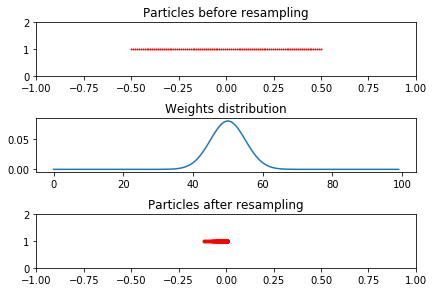

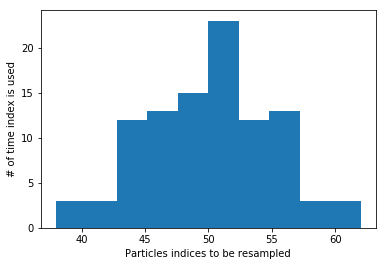

In [5]:
# CODE SNIPPET #
def normalize_weight(particles):

    sumw = sum([p.w for p in particles])

    try:
        for i in range(N_PARTICLE):
            particles[i].w /= sumw
    except ZeroDivisionError:
        for i in range(N_PARTICLE):
            particles[i].w = 1.0 / N_PARTICLE

        return particles

    return particles


def resampling(particles):
    """
    low variance re-sampling
    """

    particles = normalize_weight(particles)

    pw = []
    for i in range(N_PARTICLE):
        pw.append(particles[i].w)

    pw = np.array(pw)

    Neff = 1.0 / (pw @ pw.T)  # Effective particle number
    # print(Neff)

    if Neff < NTH:  # resampling
        wcum = np.cumsum(pw)
        base = np.cumsum(pw * 0.0 + 1 / N_PARTICLE) - 1 / N_PARTICLE
        resampleid = base + np.random.rand(base.shape[0]) / N_PARTICLE

        inds = []
        ind = 0
        for ip in range(N_PARTICLE):
            while ((ind < wcum.shape[0] - 1) and (resampleid[ip] > wcum[ind])):
                ind += 1
            inds.append(ind)

        tparticles = particles[:]
        for i in range(len(inds)):
            particles[i].x = tparticles[inds[i]].x
            particles[i].y = tparticles[inds[i]].y
            particles[i].yaw = tparticles[inds[i]].yaw
            particles[i].w = 1.0 / N_PARTICLE

    return particles, inds
# END OF SNIPPET #



def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
N_PARTICLE = 100
particles = [Particle(N_LM) for i in range(N_PARTICLE)]
x_pos = []
w = []
for i in range(N_PARTICLE):
    particles[i].x = np.linspace(-0.5,0.5,N_PARTICLE)[i]
    x_pos.append(particles[i].x)
    particles[i].w = gaussian(i, N_PARTICLE/2, N_PARTICLE/20)
    w.append(particles[i].w)
    

# Normalize weights
sw = sum(w)
for i in range(N_PARTICLE):
    w[i] /= sw

particles, new_indices = resampling(particles)
x_pos2 = []
for i in range(N_PARTICLE):
    x_pos2.append(particles[i].x)
    
# Plot results
fig, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
ax1.plot(x_pos,np.ones((N_PARTICLE,1)), '.r', markersize=2)
ax1.set_title("Particles before resampling")
ax1.axis((-1, 1, 0, 2))
ax2.plot(w)
ax2.set_title("Weights distribution")
ax3.plot(x_pos2,np.ones((N_PARTICLE,1)), '.r')
ax3.set_title("Particles after resampling")
ax3.axis((-1, 1, 0, 2))
fig.subplots_adjust(hspace=0.8)
plt.show()

plt.figure()
plt.hist(new_indices)
plt.xlabel("Particles indices to be resampled")
plt.ylabel("# of time index is used")
plt.show()

### References

http://www.probabilistic-robotics.org/

http://ais.informatik.uni-freiburg.de/teaching/ws12/mapping/pdf/slam10-fastslam.pdf